# Centrality

In this section, I'm going to learn how Centrality works and try to interpret the data based on small real dataset. I'm using Facebook DataSet from SNAP https://snap.stanford.edu/data/egonets-Facebook.html. The data is included in this repository for easier access. The data is in EdgeList format (source, target).

In [19]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import operator
import timeit

In [20]:
g_fb = nx.read_edgelist('facebook_combined.txt', create_using = nx.Graph(), nodetype = int)

In [21]:
print nx.info(g_fb)
print nx.is_directed(g_fb)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910
False


In [22]:
spring_pos = nx.spring_layout(g_fb)

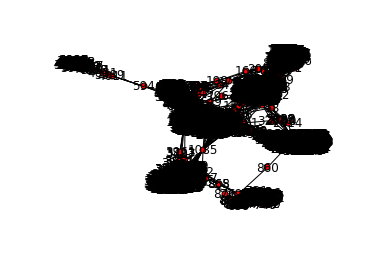

In [16]:
plt.axis('off')
nx.draw_networkx(g_fb, pos = spring_pos, with_lables=False, node_size = 35)

Now let's find the celebrities. The most basic centrality is Degree Centrality which is the sum of all in and out nodes (in the case of directed graph). 

In [23]:
dg_centrality = nx.degree_centrality(g_fb)
sorted_dg_centrality = sorted(dg_centrality.items(), key=operator.itemgetter(1), reverse=True)
sorted_dg_centrality[:10]

[(107, 0.258791480931154),
 (1684, 0.1961367013372957),
 (1912, 0.18697374938088163),
 (3437, 0.13546310054482416),
 (0, 0.08593363051015354),
 (2543, 0.07280832095096582),
 (2347, 0.07206537890044576),
 (1888, 0.0629024269440317),
 (1800, 0.06067360079247152),
 (1663, 0.058197127290737984)]

We can see that the node 107 has the highest degree centrality which means node 107 has the highest number of connected nodes. We can prove this by getting the degree of node 107 to see how many friends of node 107 has

In [24]:
nx.degree(g_fb, [107])

{107: 1045}

Node 107 has 1045 friends and we can divide that by number of nodes to get the normalized degree centrality

In [25]:
float(nx.degree(g_fb, [107]).values()[0]) / g_fb.number_of_nodes()

0.25872740777420156

Degree centrality might be the easiest number to calculate but it only shows the number of nodes connected which in real social network it might not be very useful as you might have a million followers but if the majority of them is bots then the number is not telling anything new.

Now let's try Betweenness which count all of the shortest path going throw each now. This might mean that if you have the highest shortest path going through you, you might be considered as bridge of your entire network.

Nodes with high betweenness are important in communication and information diffusion

We will be using multiprocessing so we can parallel the computation and distribute the load.

In [26]:
from multiprocessing import Pool  
import itertools

In [27]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [28]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [29]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

Let's try with multiprocesser.

It takes 124.432162046 seconds to finish
[(107, 0.4805180785560148), (1684, 0.3377974497301947), (3437, 0.23611535735892855), (1912, 0.22929533958687467), (1085, 0.14901509211665434), (0, 0.1463059214744287), (698, 0.11533045020561015), (567, 0.09631033121856315), (58, 0.0843602059079655), (428, 0.0643090623932384)]


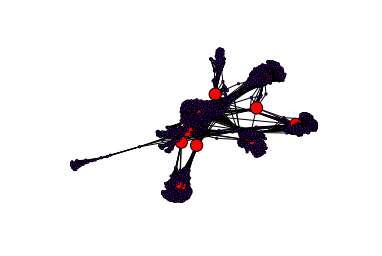

In [31]:
start = timeit.default_timer()
bt = between_parallel(g_fb)
stop = timeit.default_timer()
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(g_fb.nodes())
bt_colors = [0]*len(g_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(g_fb, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

print 'It takes {} seconds to finish'.format(stop - start)
print max_nodes

Now let's try with just one processor

It takes 229.852290154 seconds to finish
[(107, 0.48051807855601475), (1684, 0.3377974497302), (3437, 0.23611535735892797), (1912, 0.2292953395868785), (1085, 0.14901509211665198), (0, 0.14630592147442847), (698, 0.11533045020560787), (567, 0.09631033121856226), (58, 0.08436020590796657), (428, 0.0643090623932386)]


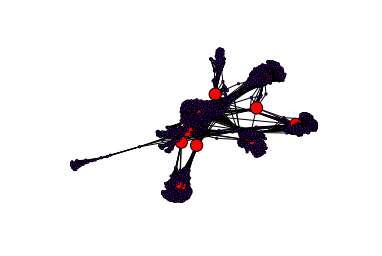

In [32]:
start = timeit.default_timer()
bt = nx.betweenness_centrality(g_fb)
stop = timeit.default_timer()
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(g_fb.nodes())
bt_colors = [0]*len(g_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(g_fb, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

print 'It takes {} seconds to finish'.format(stop - start)
print max_nodes

We would like to try Closenese Centrality. The number shows how close are you to the entire network. It's very similar to Betweenness Centrality

In [42]:
start = timeit.default_timer()
cs = nx.closeness_centrality (g_fb)
stop = timeit.default_timer()
top = 10

max_cn_nodes =  sorted(cs.iteritems(), key = lambda v: -v[1])[:top]
print 'It takes {} seconds to finish'.format(stop - start)
print max_cn_nodes

It takes 93.5353550911 seconds to finish
[(107, 0.45969945355191255), (58, 0.3974018305284913), (428, 0.3948371956585509), (563, 0.3939127889961955), (1684, 0.39360561458231796), (171, 0.37049270575282134), (348, 0.36991572004397216), (483, 0.3698479575013739), (414, 0.3695433330282786), (376, 0.36655773420479304)]


#Page rank

We're going to try PageRank algorithm. This is very similar to Google's PageRank which they use incoming links to determine the "popularity"

In [33]:
g_fb_pr = nx.pagerank(g_fb)

In [34]:
top = 10
max_pagerank = sorted(g_fb_pr.iteritems(), key = lambda v: -v[1])[:top]
max_pagerank

[(3437, 0.007614586844749602),
 (107, 0.006936420955866113),
 (1684, 0.006367162138306825),
 (0, 0.006289602618466542),
 (1912, 0.0038769716008844957),
 (348, 0.002348096972780577),
 (686, 0.0022193592598000193),
 (3980, 0.0021703235790099928),
 (414, 0.0018002990470702264),
 (698, 0.0013171153138368812)]

We can see that now the score is different as node 3437 is more popular than node 107.

# Who is a "Gray Cardinal"
There's another metric that we can measure most influential node. It's called eigenvector centrality. To put it simply it means that if you're well connected to a lot of important people that means you're important or most influential as well. 

In [35]:
g_fb_eg = nx.eigenvector_centrality(g_fb)

In [36]:
top = 10
max_eg = sorted(g_fb_eg.iteritems(), key = lambda v: -v[1])[:top]
max_eg

[(1912, 0.09540688873596533),
 (2266, 0.08698328226321961),
 (2206, 0.08605240174265634),
 (2233, 0.08517341350597848),
 (2464, 0.0842787836468596),
 (2142, 0.08419312450068117),
 (2218, 0.08415574433673877),
 (2078, 0.08413617905810125),
 (2123, 0.08367142125897375),
 (1993, 0.08353243711860492)]

Now we get quite a different result. This would mean that node 1912 is connected to more important people in the entire network that means that node is more influential than the rest of the network.

# iGraph with SNAP Facebook Dataset
Networkx is easy to install and great to start with. However, as it's written in Python it's quite slow. I'm going to try iGraph which is C based. I'm hoping that this would yield the same result but faster.

In [37]:
from igraph import *

In [38]:
igraph_fb = Graph.Read_Edgelist('facebook_combined.txt', directed=False)

In [39]:
print igraph_fb.summary()

IGRAPH U--- 4039 88234 -- 


##Betweenness

In [40]:
def betweenness_centralization(G):
    vnum = G.vcount()
    if vnum < 3:
        raise ValueError("graph must have at least three vertices")
    denom = (vnum-1)*(vnum-2)
 
    temparr = [2*i/denom for i in G.betweenness()]
    return temparr

In [41]:
start = timeit.default_timer()
igraph_betweenness = betweenness_centralization(igraph_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 5.89585280418 seconds to finish


In [55]:
igraph_betweenness.sort(reverse=True)
print igraph_betweenness[:10]

[0.4805180785560146, 0.3377974497302, 0.23611535735892794, 0.22929533958687848, 0.14901509211665237, 0.14630592147442847, 0.11533045020560788, 0.09631033121856228, 0.08436020590796657, 0.0643090623932386]


##Closeness

In [56]:
start = timeit.default_timer()
igraph_closeness = igraph_fb.closeness()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 6.03449511528 seconds to finish
[0.45969945355191255, 0.3974018305284913, 0.3948371956585509, 0.3939127889961955, 0.39360561458231796, 0.37049270575282134, 0.36991572004397216, 0.3698479575013739, 0.3695433330282786, 0.36655773420479304]


In [59]:
igraph_closeness.sort(reverse=True)
print igraph_closeness[:10]

[0.45969945355191255, 0.3974018305284913, 0.3948371956585509, 0.3939127889961955, 0.39360561458231796, 0.37049270575282134, 0.36991572004397216, 0.3698479575013739, 0.3695433330282786, 0.36655773420479304]


## EigenValue

In [63]:
start = timeit.default_timer()
igraph_eg = igraph_fb.evcent()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0605199337006 seconds to finish


In [64]:
igraph_eg.sort(reverse=True)
print igraph_eg[:10]

[1.0, 0.9117190175727692, 0.9019626322184224, 0.8927488203018574, 0.8833723691600276, 0.8824740496738565, 0.8820826938160453, 0.8818776189568697, 0.8770062766705495, 0.8755494858467853]


## PageRank

In [65]:
start = timeit.default_timer()
igraph_pr = igraph_fb.pagerank()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0709159374237 seconds to finish


In [66]:
igraph_pr.sort(reverse=True)
print igraph_pr[:10]

[0.0075745665246258935, 0.006888375869731625, 0.0063084887921967805, 0.0062246948047383005, 0.0038165503710367713, 0.002317366308283276, 0.002216791818397391, 0.002156551114912813, 0.0017822888082657136, 0.00129416751155367]


We can see that iGraph yields similar result from networkx but it's a lot quicker in the same machine.

# Graph_tool with SNAP Facebook Dataset
I'm going to try another library which is supposed to be the fastest than networkx and igraph. Graph_tool is also C based which it has OpenMP enabled so a lot of algorithms is multiprocessing. 

In [67]:
import sys
sys.path.append('/usr/lib/python2.7/dist-packages')

from graph_tool.all import *
import timeit

In [68]:
show_config()

version: 2.2.44 (commit 178add3a, Thu Jul 2 01:44:54 2015 +0200)
gcc version: 4.8.2
compilation flags: -D_FORTIFY_SOURCE=2 -I/usr/include/python2.7 -I/usr/include -I/usr/lib/python2.7/dist-packages/numpy/core/include -I/usr/lib/python2.7/dist-packages/scipy -I/usr/include -DSPARSEHASH_PREFIX=google -Wall -Wextra -ftemplate-backtrace-limit=0 -O3 -DNDEBUG -std=gnu++11 -ftemplate-depth-250 -Wno-deprecated -Wno-unknown-pragmas -O3 -fvisibility=default -fvisibility-inlines-hidden -fopenmp -I/usr/include -DSPARSEHASH_PREFIX=google -Wl,-Bsymbolic-functions -Wl,-z,relro -L/usr/lib -lpython2.7
install prefix: /usr
python dir: /usr/lib/python2.7/dist-packages
graph filtering: True
openmp: True
uname: Linux ip-172-31-45-186 3.13.0-48-generic #80-Ubuntu SMP Thu Mar 12 11:16:15 UTC 2015 x86_64


In [69]:
graph_tool_fb = Graph(directed=False)

In [70]:
with open('facebook_combined.txt', 'r') as f:
    for line in f:
        edge_list = line.split()
        source, target = tuple(edge_list)
        graph_tool_fb.add_edge(source, target)

In [71]:
print graph_tool_fb.num_vertices()
print graph_tool_fb.num_edges()

4039
88234


## Betweeness

In [74]:
start = timeit.default_timer()
vertext_betweenness, edge_betweenness = betweenness(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 7.47633004189 seconds to finish


In [75]:
vertext_betweenness.a[107]

0.48051807855601453

## Closeness

In [77]:
start = timeit.default_timer()
v_closeness = closeness(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 7.69668292999 seconds to finish


In [78]:
v_closeness.a[107]

0.45969945355191255

## Eigenvalue

In [79]:
start = timeit.default_timer()
v_closeness = eigenvector(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0300698280334 seconds to finish


## Page Rank

In [80]:
start = timeit.default_timer()
v_closeness = pagerank(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0744159221649 seconds to finish


# Information diffusion modelling
I'm going to information diffusion model to simulate how information travels in the graph. 

In [72]:
%matplotlib inline
import random as r
import networkx as nx
import matplotlib.pyplot as plot

In [67]:
class Person(object):
    def __init__(self, id):
        #Start with a single initial preference
        self.id = id
        self.i = r.random()
        self.a = self.i
        # we value initial opinion and subsequent information equally
        self.alpha = 0.8
    
    def __str__(self):
        return (str(self.id))
    
    def step(self):
        # loop through the neighbors and aggregate their preferences
        neighbors = g[self]
        # all nodes in the list of neighbors are equally weighted, including self
        w = 1/float((len(neighbors) + 1 ))
        s = w * self.a
        for node in neighbors:
            s += w * node.a

        # update my beliefs = initial belief plus sum of all influences
        self.a = (1 - self.alpha) * self.i + self.alpha * s

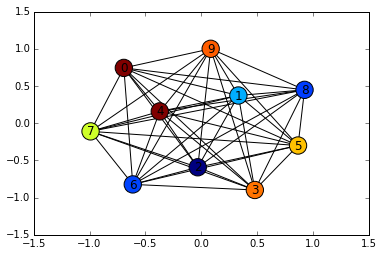

In [68]:
density = 0.9
g = nx.Graph()

## create a network of Person objects
for i in range(10):
    p = Person(i)
    g.add_node(p)
    
## this will be a simple random graph, every pair of nodes has an
## equal probability of connection
for x in g.nodes():
    for y in g.nodes():
        if r.random() <= density:
            g.add_edge(x,y)
            
## draw the resulting graph and color the nodes by their value
col = [n.a for n in g.nodes()]
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos=pos, node_color=col)

[0.59481869665453, 0.4787054986169703, 0.6345786324574545, 0.5583406511205509, 0.4998780934479225, 0.4433062597303738, 0.5782786039258474, 0.5941385554122159, 0.6282667334091848, 0.48009435883638785]
[0.59481869665453, 0.4787054986169703, 0.6345786324574545, 0.5583406511205509, 0.4998780934479225, 0.4433062597303738, 0.5782786039258474, 0.5941385554122159, 0.6282667334091848, 0.48009435883638785]
[0.59481869665453, 0.4787054986169703, 0.6345786324574545, 0.5583406511205509, 0.4998780934479225, 0.4433062597303738, 0.5782786039258474, 0.5941385554122159, 0.6282667334091848, 0.48009435883638785]
[0.59481869665453, 0.4787054986169703, 0.6345786324574545, 0.5583406511205509, 0.4998780934479225, 0.4433062597303738, 0.5782786039258474, 0.5941385554122159, 0.6282667334091848, 0.48009435883638785]
[0.59481869665453, 0.4787054986169703, 0.6345786324574545, 0.5583406511205509, 0.4998780934479225, 0.4433062597303738, 0.5782786039258474, 0.5941385554122159, 0.6282667334091848, 0.48009435883638785]


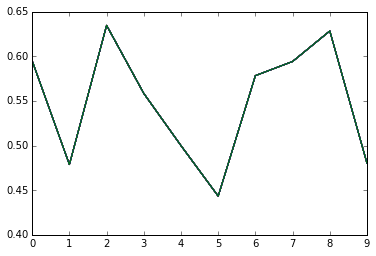

In [80]:
## repeat for 30 times periods
for i in range(30):
    ## iterate through all nodes in the network and tell them to make a step
    for node in g.nodes():
        node.step()
        
    ## collect new attitude data, print it to the terminal and plot it.
    col = [n.a for n in g.nodes()]
    print col
    plot.plot(col)

In [81]:
class Influencer(Person):
    def __ini__(self, id):
        self.id = id
        self.i = r.random()
        self.a = 1 ## opinion is strong and immovable
        
    def step(self):
        pass

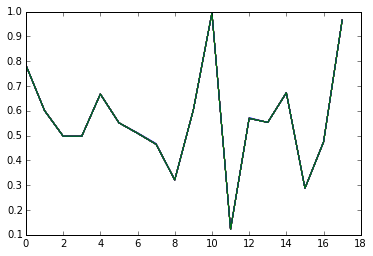

In [86]:
influencers = 2
connections = 4
## add the influencers to the network and connect each to 3 other nodes
for i in range(influencers):
    inf = Influencer("Inf" + str(i))
    for x in range(connections):
        g.add_edge(r.choice(g.nodes()), inf)
        
## repeat for 30 time periods
for i in range(30):
    ## iterate through all nodes in the network and tell them to make a step
    for node in g.nodes():
        node.step()
        
    ## collect new attitude data, print it to the terminal and plot it.
    col = [n.a for n in g.nodes()]
    #print col
    plot.plot(col)

# iGraph Network Diffusion

In [100]:
from igraph import *

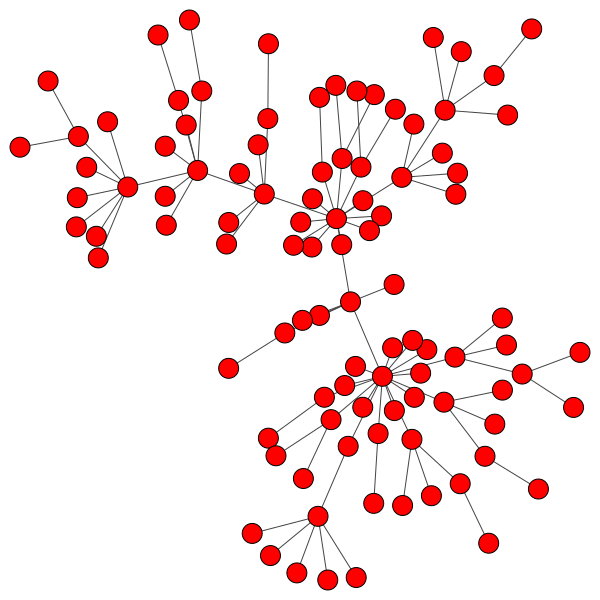

In [104]:
node_number = 100
barabasi = Graph.Barabasi(node_number)
plot(barabasi)

# Networkx Independent Cascade Model

In [118]:
import copy
import networkx as nx
import random

In [119]:
def independent_cascade(G, seeds, steps=0):
  """Return the active nodes of each diffusion step by the independent cascade
  model

  Parameters
  -----------
  G : graph
    A NetworkX graph
  seeds : list of nodes
    The seed nodes for diffusion
  steps: integer
    The number of steps to diffuse.  If steps <= 0, the diffusion runs until
    no more nodes can be activated.  If steps > 0, the diffusion runs for at
    most "steps" rounds

  Returns
  -------
  layer_i_nodes : list of list of activated nodes
    layer_i_nodes[0]: the seeds
    layer_i_nodes[k]: the nodes activated at the kth diffusion step

  Notes
  -----
  When node v in G becomes active, it has a *single* chance of activating
  each currently inactive neighbor w with probability p_{vw}

  Examples
  --------
  >>> DG = nx.DiGraph()
  >>> DG.add_edges_from([(1,2), (1,3), (1,5), (2,1), (3,2), (4,2), (4,3), \
  >>>   (4,6), (5,3), (5,4), (5,6), (6,4), (6,5)], act_prob=0.2)
  >>> H = nx.independent_cascade(DG,[6])

  References
  ----------
  [1] David Kempe, Jon Kleinberg, and Eva Tardos.
      Influential nodes in a diffusion model for social networks.
      In Automata, Languages and Programming, 2005.
  """
  if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph:
      raise Exception( \
          "independent_cascade() is not defined for graphs with multiedges.")

  # make sure the seeds are in the graph
  for s in seeds:
    if s not in G.nodes():
      raise Exception("seed", s, "is not in graph")

  # change to directed graph
  if not G.is_directed():
    DG = G.to_directed()
  else:
    DG = copy.deepcopy(G)

  # init activation probabilities
  for e in DG.edges():
    if 'act_prob' not in DG[e[0]][e[1]]:
      DG[e[0]][e[1]]['act_prob'] = 0.1
    elif DG[e[0]][e[1]]['act_prob'] > 1:
      raise Exception("edge activation probability:", \
          DG[e[0]][e[1]]['act_prob'], "cannot be larger than 1")

  # perform diffusion
  A = copy.deepcopy(seeds)  # prevent side effect
  if steps <= 0:
    # perform diffusion until no more nodes can be activated
    return _diffuse_all(DG, A)
  # perform diffusion for at most "steps" rounds
  return _diffuse_k_rounds(DG, A, steps)

In [120]:
def _diffuse_all(G, A):
  tried_edges = set()
  layer_i_nodes = [ ]
  layer_i_nodes.append([i for i in A])  # prevent side effect
  while True:
    len_old = len(A)
    (A, activated_nodes_of_this_round, cur_tried_edges) = \
        _diffuse_one_round(G, A, tried_edges)
    layer_i_nodes.append(activated_nodes_of_this_round)
    tried_edges = tried_edges.union(cur_tried_edges)
    if len(A) == len_old:
      break
  return layer_i_nodes

In [121]:
def _diffuse_k_rounds(G, A, steps):
  tried_edges = set()
  layer_i_nodes = [ ]
  layer_i_nodes.append([i for i in A])
  while steps > 0 and len(A) < len(G):
    len_old = len(A)
    (A, activated_nodes_of_this_round, cur_tried_edges) = \
        _diffuse_one_round(G, A, tried_edges)
    layer_i_nodes.append(activated_nodes_of_this_round)
    tried_edges = tried_edges.union(cur_tried_edges)
    if len(A) == len_old:
      break
    steps -= 1
  return layer_i_nodes

In [122]:
def _diffuse_one_round(G, A, tried_edges):
  activated_nodes_of_this_round = set()
  cur_tried_edges = set()
  for s in A:
    for nb in G.successors(s):
      if nb in A or (s, nb) in tried_edges or (s, nb) in cur_tried_edges:
        continue
      if _prop_success(G, s, nb):
        activated_nodes_of_this_round.add(nb)
      cur_tried_edges.add((s, nb))
  activated_nodes_of_this_round = list(activated_nodes_of_this_round)
  A.extend(activated_nodes_of_this_round)
  return A, activated_nodes_of_this_round, cur_tried_edges

def _prop_success(G, src, dest):
  return random.random() <= G[src][dest]['act_prob']

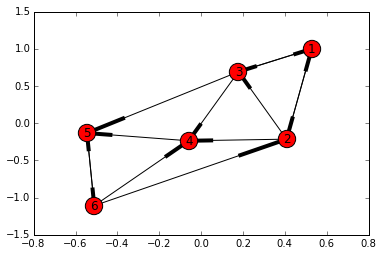

In [123]:
run_times = 10

G = nx.DiGraph()
G.add_edge(1,2,act_prob=.5)
G.add_edge(2,1,act_prob=.5)
G.add_edge(1,3,act_prob=.2)
G.add_edge(3,1,act_prob=.2)
G.add_edge(2,3,act_prob=.3)
G.add_edge(2,4,act_prob=.5)
G.add_edge(3,4,act_prob=.1)
G.add_edge(3,5,act_prob=.2)
G.add_edge(4,5,act_prob=.2)
G.add_edge(5,6,act_prob=.6)
G.add_edge(6,5,act_prob=.6)
G.add_edge(6,4,act_prob=.3)
G.add_edge(6,2,act_prob=.4)
nx.draw_networkx(G)

In [142]:
independent_cascade(G, [1], steps=1)

[[1], []]

In [ ]:
n_A = 0.0
for i in range(run_times):
    A = independent_cascade(G, [2], steps=1)
    print A
    for layer in A:
        n_A += len(layer)
n_A / run_times
#assert_almost_equal(n_A / run_times, 1.7, places=1)

#Conclusion

Both igraph and graph_tool yield similar performance. So, for the real data I'm going to use graph_tool as the documentation is more comprehensive.

# Real data
The data we collect from Twitter Streaming API is stored in Mongodb.

In [49]:
%matplotlib inline
import pymongo
import networkx as nx
import time
import itertools
import operator

from multiprocessing import Pool
from pymongo import MongoClient

from sweepy.get_config import get_config

config = get_config()

MONGO_URL = config.get('MONGO_URL')
MONGO_PORT = config.get('MONGO_PORT')
MONGO_USERNAME = config.get('MONGO_USERNAME')
MONGO_PASSWORD = config.get('MONGO_PASSWORD')
MONGO_DATABASE = config.get('MONGO_DATABASE')

client = MongoClient(MONGO_URL, int(MONGO_PORT))

db = client[MONGO_DATABASE]
db.authenticate(MONGO_USERNAME, MONGO_PASSWORD)

users = db.users
raw_tweets = db.raw_tweets

Let's do some data exploration first.

## Who retweet the most in Fusion network

In [14]:
most_retweets = raw_tweets.aggregate([
    { '$group' : { '_id': '$user.id_str', 'count' : { '$sum' : 1 }, 'screen_name' : { '$last' : '$user.screen_name'} } },
    { '$match' : { 'count' : { '$gte' : 1 } } },
    { '$sort' : { 'count' : -1 } },
    { '$limit' : 20}
])

In [15]:
for most_retweet in most_retweets:
    print most_retweet

{u'count': 1424, u'_id': u'121817564', u'screen_name': u'ThisIsFusion'}
{u'count': 423, u'_id': u'3106528812', u'screen_name': u'JuePier'}
{u'count': 248, u'_id': u'220038215', u'screen_name': u'prattreport'}
{u'count': 100, u'_id': u'3152407786', u'screen_name': u'Urbaniters'}
{u'count': 77, u'_id': u'7154912', u'screen_name': u'ohiomary'}
{u'count': 59, u'_id': u'151938942', u'screen_name': u'mauriciogale'}
{u'count': 52, u'_id': u'34294546', u'screen_name': u'EmeraldEnvy11'}
{u'count': 47, u'_id': u'3152728781', u'screen_name': u'SocialCurrentcy'}
{u'count': 45, u'_id': u'789920724', u'screen_name': u'felicito15'}
{u'count': 40, u'_id': u'200249089', u'screen_name': u'jnarls'}
{u'count': 37, u'_id': None, u'screen_name': None}
{u'count': 37, u'_id': u'630864427', u'screen_name': u'NDaddyP'}
{u'count': 31, u'_id': u'145062328', u'screen_name': u'VivianIPadilla'}
{u'count': 31, u'_id': u'1114746523', u'screen_name': u'no2hitting'}
{u'count': 30, u'_id': u'1921038272', u'screen_name': 

## More retweeted tweet

In [98]:
most_retweeted_tweets = raw_tweets.aggregate([
    { '$group': { '_id' : '$retweeted_status.id_str', 'count' : { '$sum' : 1 }, 't' : { '$last' : '$retweeted_status.text'} }},
    { '$match': { 'count' : { '$gte' : 1} }  },
    { '$sort' : { 'count' : -1 } },
    { '$limit' : 20 }
])

In [99]:
for most_retweet in most_retweeted_tweets:
    print most_retweet

{u'count': 3258, u'_id': None, u't': None}
{u'count': 1408, u'_id': u'636345902915911680', u't': u'Jorge Ramos: Donald Trump\u2019s immigration plan is \u2018all wrong\u2019 and \u2018impossible to achieve\u2019\nhttps://t.co/Y4pojxTzX7'}
{u'count': 402, u'_id': u'634458360679501824', u't': u'The American lawn is now the largest single "crop" in the U.S. http://t.co/pXgNr9mrJg http://t.co/8FYA1vjDQe'}
{u'count': 338, u'_id': u'636606180094115840', u't': u'Donald Trump supporter to Jorge Ramos: \u201cGet out of my country.\u201d\nhttps://t.co/saeDo5mJ5j'}
{u'count': 320, u'_id': u'634459019990536192', u't': u'The American lawn is now the largest single "crop" in the U.S. http://t.co/zalV0EE8Gu http://t.co/M3txMmzg5m'}
{u'count': 275, u'_id': u'643503547624071170', u't': u'Immigrant takes Donald Trump\u2019s job http://t.co/DZrh8ZCVlR http://t.co/W3zSvkLfUh'}
{u'count': 209, u'_id': u'634458268333510657', u't': u'Meet the Silicon Valley CEO who is championing women. http://t.co/ZVYLZym41

In [ ]:
all_users = users.find({}, { 'id' : 1, 'friends_ids' : 1}).batch_size(50)

We are going to convert the data to edgelist so it's easier to import to various different tools

In [8]:
with open('twitter_edgelist.txt', 'w') as f:
    for user in all_users:
        u_id = str(abs(user['id']))
        for friend_id in user['friends_ids']:
            f_id = str(abs(friend_id))
            f.write('{} {}\n'.format(u_id, f_id))

## Let's try ICM with iGraph

In [146]:
from igraph import *
import copy

In [147]:
def independent_cascade_igraph(G, seeds, steps=0):
    # init activation probabilities
    for e in G.es():
        if 'act_prob' not in e.attributes():
            e['act_prob'] = 0.1
        elif e['act_prob'] > 1:
            raise Exception("edge activation probability:", e['act_prob'], "cannot be larger than 1")

    # perform diffusion
    A = copy.deepcopy(seeds)  # prevent side effect
    if steps <= 0:
        # perform diffusion until no more nodes can be activated
        return _diffuse_all(G, A)
    # perform diffusion for at most "steps" rounds
    return _diffuse_k_rounds(G, A, steps)

In [148]:
def _diffuse_k_rounds(G, A, steps):
    tried_edges = set()
    layer_i_nodes = [ ]
    layer_i_nodes.append([i for i in A])
    while steps > 0 and len(A) < G.vcount():
        len_old = len(A)
        (A, activated_nodes_of_this_round, cur_tried_edges) = _diffuse_one_round(G, A, tried_edges)
        layer_i_nodes.append(activated_nodes_of_this_round)
        tried_edges = tried_edges.union(cur_tried_edges)
        if len(A) == len_old:
            break
        steps -= 1
    return layer_i_nodes

In [201]:
def _diffuse_one_round(G, A, tried_edges):
    activated_nodes_of_this_round = set()
    cur_tried_edges = set()
    for s in A:
        for nb in G.successors(s):
            if nb in A or (s, nb) in tried_edges or (s, nb) in cur_tried_edges:
                continue
            if _prop_success(G, s, nb):
                activated_nodes_of_this_round.add(nb)
            cur_tried_edges.add((s, nb))
    activated_nodes_of_this_round = list(activated_nodes_of_this_round)
    A.extend(activated_nodes_of_this_round)
    return A, activated_nodes_of_this_round, cur_tried_edges

def _prop_success(G, src, dest):
    '''
    act_prob = 0.1
    for e in G.es():
        if (src, dest) == e.tuple:
            act_prob = e['act_prob']
            break
    '''
    return random.random() <= 0.1

In [202]:
test_g = Graph([(1,2), (2,1), (1,3), (3,1), (2,3), (2,4), (3,4), (3,5), (4,5), (5,6), (6,5), (6,4), (6,2)], directed=True)
test_g.es['act_prob'] = [.5, .5, .2, .2, .3, .5, .1, .2, .2, .6, .6, .3, .4]

In [203]:
independent_cascade_igraph(test_g, [1], steps=1)

[[1], []]

# Find Centrality

In [204]:
from igraph import *
import timeit
import numpy

In [176]:
twitter_igraph = Graph.Read_Ncol('twitter_edgelist.txt', directed=True)

In [177]:
print twitter_igraph.summary()

IGRAPH DN-- 2869228 6764984 -- 
+ attr: name (v)


In [209]:
thisisfusion = twitter_igraph.vs.find(name='121817564')
print thisisfusion.degree(type="out")
print thisisfusion.index

1907
139


In [211]:
len(twitter_igraph.successors(139))

1907

In [205]:
independent_cascade_igraph(twitter_igraph, ['121817564'], steps=1)

[['121817564'],
 [2049,
  516,
  1032,
  521,
  1548,
  1551,
  533,
  1563,
  1882,
  1056,
  1571,
  1061,
  1372,
  1580,
  563,
  1033,
  1592,
  569,
  570,
  1595,
  573,
  1598,
  1973,
  1088,
  584,
  268,
  588,
  1107,
  1110,
  1111,
  1626,
  603,
  1629,
  1120,
  1638,
  616,
  1642,
  1643,
  1132,
  1981,
  1651,
  122,
  1149,
  1663,
  1984,
  644,
  648,
  1388,
  1303,
  482,
  1170,
  1683,
  660,
  1685,
  664,
  1690,
  1691,
  670,
  675,
  369,
  1608,
  682,
  1708,
  1203,
  694,
  1207,
  1210,
  1723,
  970,
  1694,
  1731,
  1738,
  715,
  717,
  1741,
  209,
  212,
  732,
  739,
  1769,
  747,
  237,
  238,
  1661,
  754,
  1275,
  1834,
  1793,
  259,
  1802,
  780,
  898,
  1297,
  1298,
  276,
  1301,
  279,
  284,
  1314,
  1827,
  1316,
  1322,
  1459,
  814,
  823,
  824,
  831,
  1345,
  1858,
  838,
  1351,
  1865,
  1354,
  1847,
  845,
  848,
  227,
  1367,
  345,
  858,
  348,
  1885,
  1887,
  1380,
  1381,
  1169,
  873,
  1899,
  364,
  141

In [206]:
twitter_igraph.vs[2049]

igraph.Vertex(<igraph.Graph object at 0x7f5576360a00>,2049,{'name': '54043630'})

In [32]:
start = timeit.default_timer()
igraph_eg = twitter_igraph.evcent()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 23.0463728905 seconds to finish


In [52]:
np_vals = numpy.array(igraph_eg)
sorted_eigen = numpy.argsort(np_vals)[::-1][:100]

In [53]:
for eg in sorted_eigen:
    t_id = twitter_igraph.vs.find(eg)['name']
    u = users.find_one({'id_str' : str(t_id)})
    if u:
        print u['screen_name']
    else:
        print t_id

ThisIsFusion
alexismadrigal
807095
AnnaHolmes
isaacleep
58524428
kevinroose
14677919
AliciaMenendez
FusionNews
51241574
felixsalmon
dodaistewart
jorgeramosnews
nuriapuntonet
thisisjorge
35773039
kashhill
813286
LatoyaPeterson
18622869
9149492
14515799
nandorvila
122188108
hilella
16017475
243822289
ItsDavidFord
1339835893
27000730
AkilahObviously
2517988075
TheRealFuture
rjwile
9532402
25074661
2467791
21924525
Cleomsf
291748457
TooMuchMe
16076032
5392522
FusionPop
45564482
428333
collier
1536791610
2347049341
3108351
5695632
FusionSnaps
15959440
CharlesPulliam
15164565
8936082
10454572
1140451
fidmart85
ABC
30313925
25294855
14834340
15865878
1652541
14849562
31080039
ComeHereSayThat
5988062
6017542
DaniAFriedman
18510860
80350164
24773177
joseiswriting
281607245
mollyfitz
AdamWeinstein
4265721
WIRED
15087011
adamauriemma
WeAreFusion
14075928
972651
16955991
16012783
RojasIngrid
9300262
ThisIsAmerica
14511951
19725644
47632905
20605481
16129920
24216951
5402612
13566872
138141150


In [91]:
start = timeit.default_timer()
igraph_pr = twitter_igraph.pagerank()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 1.9402821064 seconds to finish


In [92]:
np_vals = numpy.array(igraph_pr)
sorted_pr = numpy.argsort(np_vals)[::-1][:100]

In [93]:
for eg in sorted_pr:
    t_id = twitter_igraph.vs.find(eg)['name']
    u = users.find_one({'id_str' : str(t_id)})
    if u:
        print u['screen_name']
    else:
        print t_id

ThisIsFusion
Unpredictable1D
813286
jorgeramosnews
807095
1536791610
428333
15846407
759251
1339835893
51241574
2467791
16303106
30313925
15485441
158414847
25073877
5402612
14511951
3108351
15224867
5392522
ABC
50393960
11348282
19725644
742143
1652541
27195114
500704345
5988062
14677919
14293310
1330457336
169686021
14075928
1093090866
19697415
20609518
16129920
17471979
29442313
25365536
5695632
WIRED
17919972
6017542
79293791
115485051
UniNoticias
216776631
316389142
19028953
26257166
972651
19397785
10228272
1367531
21447363
Univision
2557521
91478624
14173315
9300262
176566242
45266183
27260086
35773039
783214
34507480
15012486
15492359
23818581
18510860
3303293865
16664681
deray
236699098
95023423
80654397
14159148
44409004
166739404
33884545
180505807
26565946
87818409
15164565
181561712
409486555
255388236
2097571
23375688
157140968
37710752
14230524
134381889
485272230
FusionNews
30364057


# Graph tool

In [7]:
import sys
import os
sys.path.append('/usr/lib/python2.7/dist-packages')

from graph_tool.all import *

In [8]:
g = Graph(directed=True)

In [9]:
with open('twitter_edgelist.txt', 'r') as f:
    for line in f:
        edge_list = line.split()
        source, target = tuple(edge_list)
        g.add_edge(source, target)

MemoryError: 

In [ ]:
print g.num_vertices()
print g.num_edges()

In [16]:
v = g.add_vertex()
vprop_string[v] = 'id'

In [ ]:
find_vertex(g, g.vertex_properties[''])

In [19]:
print 'Processing first 1000 batch'
for idx, user in enumerate(all_users):
    if idx and not idx % 1000:
        print 'Processing {} batch'.format(idx)
        
    u_id = str(user['id_str'])
    v = g.add_vertex(1)
    
    for friend_id in user['friends_ids']:
        f_id = str(friend_id)
        f = g.add_vertex(1)
        g.add_edge(v, f)

Processing first 1000 batch
Processing 1000 batch
Processing 2000 batch
Processing 3000 batch
Processing 4000 batch
Processing 5000 batch


In [ ]:
graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=12, output_size=(1000, 1000))

10
